In [1]:
# A későbbiekben felhasznált csomagok importálása

import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import re
from openai import OpenAI
import yaml

In [2]:
# Az egyes oldalakról az URL, cím, dátum, tartalom adatok parseolása

def parse_page(soup):
    result=[]
    articles = soup.find_all('article', class_='oxy-post')
    for article in articles:
        a_tag = article.find('a', class_='oxy-post-title')
        title = a_tag.text.strip()
        link = a_tag['href']
        # Dátum
        date_div = article.find('div', class_='oxy-post-meta-date')
        date = date_div.text.strip() if date_div else 'N/A'
        # Tartalom
        content_div = article.find('div', class_='oxy-post-content')
        content = content_div.text.strip() if content_div else 'N/A'
        result.append([title, link, date, content])
    if not result:
            return True, []
    return False, result

# A keresőszó alapján megnyitom az URL-(eke)t és parse-olom az oldalakon lévő cikkek adatait
def get_urls_from_kiszamolo(search_text):
    articles = []
    page = 1
    last_page = False
    while not last_page:
        url = f"https://kiszamolo.hu/page/{page}/?s={search_text}" if page > 1 else f"https://kiszamolo.hu/?s={search_text}"    
        response = requests.get(url)
        response.encoding = 'utf-8'
        soup = BeautifulSoup(response.text, 'html.parser')
        last_page, new_articles = parse_page(soup)
        articles.extend(new_articles)
        page +=1
    return articles

In [3]:
# Itt lehet megadni, hogy milyen keresőszó-val kérjük le a cikkeket
# A 'revolut' keresőszó pl. 86 cikk találatot ad jelen pillanatban.
# Sajnos van olyan cikk, ami nem kifejezetten a revultról szól, de persze meg van benne említve

articles = get_urls_from_kiszamolo('revolut')
articles_df = pd.DataFrame(articles, columns=["Title","Link","Article_date","Content"])
articles_df

,Title,Link,Article_date,Content
0,Lightyear válasz,https://kiszamolo.hu/lightyear-valasz/,2025-01-15,"Írtam egy cikket, hogy szerintem komoly pénzt ..."
1,TBSZ már a Lightyearnél is,https://kiszamolo.hu/tbsz-mar-a-lightyearnel-is/,2024-01-11,"Az Interactive Brokersnek évekbe telt, mire si..."
2,"Lightyear, a szinte ingyenes brókercég",https://kiszamolo.hu/lightyear-a-szinte-ingyen...,2023-04-11,A múlt héten (amikor is a tavaszi szünet miatt...


In [4]:
# A kigyűjtött cikkekből itt történik meg a kommentek parse-olása

# Segédfüggvény, a div-ekből dict típusban adja vissza a kinyert adatokat
def get_comment_from_div(div):
    comment_id = div.get("id", "")
    author = div.find("div", class_="wpd-comment-author")
    date = div.find("div", class_="wpd-comment-date")
    text = div.find("div", class_="wpd-comment-text")
    votes = div.find("div", class_="wpd-vote-result")
    return {
        "comment_id": comment_id,
        "author": author.get_text(strip=True) if author else None,
        "date": date.get("title") if date and date.has_attr("title") else None,
        "text": text.get_text(strip=True) if text else None,
        "votes": votes.get_text(strip=True) if votes else "0"
    }

# A HTML-ben ajax hívások is lehetnek, amelyek további kommenteket töltenek be
# Az ajax hívások kommentjeit itt gyűjtöm össze
def parse_ajax_comments(soup, total_ajax_comments, last_parent):
    ajax_comments = []
    shortlink = soup.find("link", rel="shortlink")
    post_id = None
    if shortlink and "?p=" in shortlink["href"]:
        post_id = shortlink["href"].split("?p=")[-1]
    offset = 1
    ajax_url = "https://kiszamolo.hu/wp-admin/admin-ajax.php"
    while len(ajax_comments) < total_ajax_comments:
        payload = {
            "action": "wpdLoadMoreComments",
            "sorting": "oldest",
            "offset": offset,
            "lastParentId": last_parent,
            "isFirstLoad": 0,
            "wpdType": "post",
            "postId": post_id,
        }
        response = requests.post(ajax_url, data=payload)
        html = response.json()["data"]['comment_list']
        soup = BeautifulSoup(html, 'html.parser')
        comment_divs = soup.find_all("div", class_="wpd-comment")
        for div in comment_divs:
            comment = get_comment_from_div(div)
            ajax_comments.append(comment)
        last_parent = comment_divs[-1].get("id").replace("wpd-comm-", "").split('_')[0] if comment_divs else 0
        offset += 1
    return ajax_comments

# Az url alapján parse-olom a kommenteket
# Ha kevesebb komment van, mint amennyit a wpd-thread-info class mutat, akkor ajax hívásokkal jön a többi
# (az újabb cikkek esetében már nincsenek ajax hívások, de korábban voltak)
def parse_comments(url):
    response = requests.get(url)
    response.encoding = 'utf-8'
    soup = BeautifulSoup(response.text, 'html.parser')
    info_div = soup.find("div", class_="wpd-thread-info")
    total_comments = int(info_div["data-comments-count"]) if info_div else 0
    comment_divs = soup.find_all("div", class_="wpd-comment")
    comments=[]
    for div in comment_divs:
        comment = get_comment_from_div(div)
        comments.append(comment)
    if len(comments) >= total_comments:
        return comments
    else:
        last_parent = comment_divs[-1].get("id").replace("wpd-comm-", "").split('_')[0] if comment_divs else 0
        total_ajax_comments = total_comments - len(comments)
        ajax_comments = parse_ajax_comments(soup, total_ajax_comments, last_parent)
        return comments + ajax_comments

# Az article linkek alapján készítünk egy df-et a kommentekkel, 9894 db van jelenleg
all_comments = []
for link in articles_df["Link"]:
    comments = parse_comments(link)  # list of dict-ek
    for c in comments:
        c["article_link"] = link   # hozzátesszük a cikk linkjét, hogy tudjuk honnan jött
        all_comments.append(c)

comments_df = pd.DataFrame(all_comments)
comments_df

,comment_id,author,date,text,votes,article_link
0,wpd-comm-349939_0,Inevitable,2025-01-15 19:02,"Nagyon szimpatikus, hogy a válaszukat is lehoz...",0,https://kiszamolo.hu/lightyear-valasz/
1,wpd-comm-349961_349939,Cee,2025-01-15 22:00,A központi értéktárak (CSD-k) a befektetési sz...,0,https://kiszamolo.hu/lightyear-valasz/
2,wpd-comm-349971_349939,Szabó Péter,2025-01-16 07:09,"Ezt én is kérdeztem már tőlük e-mailben, nincs...",0,https://kiszamolo.hu/lightyear-valasz/
3,wpd-comm-349977_349939,Vazul néni,2025-01-16 08:57,Nagyon korrekt Miklóstól hogy közzétette a LY ...,0,https://kiszamolo.hu/lightyear-valasz/
4,wpd-comm-349940_0,Vérboci,2025-01-15 19:07,Korrekt válasz. Engem meggyőzött. A pmápból li...,0,https://kiszamolo.hu/lightyear-valasz/
...,...,...,...,...,...,...
198,wpd-comm-339804_304673,Kiszamolo,2023-04-11 08:16,Egyszerre? Még a magyar betétbiztosítás sem tu...,0,https://kiszamolo.hu/lightyear-a-szinte-ingyen...
199,wpd-comm-315399_0,Eszef,2023-04-12 12:31,@zabalint Köszönöm!,0,https://kiszamolo.hu/lightyear-a-szinte-ingyen...
200,wpd-comm-315400_0,Gergő,2023-04-12 10:40,(folyt)-Mielőtt az Erstet otthagytam volt egy ...,0,https://kiszamolo.hu/lightyear-a-szinte-ingyen...
201,wpd-comm-315402_0,ETF vásárló,2023-04-12 10:54,Ha valaki @gergo -höz hasonló módon szeretne S...,0,https://kiszamolo.hu/lightyear-a-szinte-ingyen...


In [5]:
# Néha előfordul, hogy egy komment dátuma évekkel korábbi, mint a cikké.
# Ha ilyet találok, a komment dátumának a cikk dátumát adjom meg

comments_df['date'] = pd.to_datetime(comments_df['date'])
articles_df['Article_date'] = pd.to_datetime(articles_df['Article_date'])

merged = comments_df.merge(articles_df[['Link', 'Article_date']], left_on='article_link', right_on='Link', suffixes=('', '_article'))
merged.loc[merged['date'] < merged['Article_date'], 'date'] = merged.loc[merged['date'] < merged['Article_date'], 'Article_date']

comments_df['date'] = merged['date']
comments_df

,comment_id,author,date,text,votes,article_link
0,wpd-comm-349939_0,Inevitable,2025-01-15 19:02:00,"Nagyon szimpatikus, hogy a válaszukat is lehoz...",0,https://kiszamolo.hu/lightyear-valasz/
1,wpd-comm-349961_349939,Cee,2025-01-15 22:00:00,A központi értéktárak (CSD-k) a befektetési sz...,0,https://kiszamolo.hu/lightyear-valasz/
2,wpd-comm-349971_349939,Szabó Péter,2025-01-16 07:09:00,"Ezt én is kérdeztem már tőlük e-mailben, nincs...",0,https://kiszamolo.hu/lightyear-valasz/
3,wpd-comm-349977_349939,Vazul néni,2025-01-16 08:57:00,Nagyon korrekt Miklóstól hogy közzétette a LY ...,0,https://kiszamolo.hu/lightyear-valasz/
4,wpd-comm-349940_0,Vérboci,2025-01-15 19:07:00,Korrekt válasz. Engem meggyőzött. A pmápból li...,0,https://kiszamolo.hu/lightyear-valasz/
...,...,...,...,...,...,...
198,wpd-comm-339804_304673,Kiszamolo,2023-04-11 08:16:00,Egyszerre? Még a magyar betétbiztosítás sem tu...,0,https://kiszamolo.hu/lightyear-a-szinte-ingyen...
199,wpd-comm-315399_0,Eszef,2023-04-12 12:31:00,@zabalint Köszönöm!,0,https://kiszamolo.hu/lightyear-a-szinte-ingyen...
200,wpd-comm-315400_0,Gergő,2023-04-12 10:40:00,(folyt)-Mielőtt az Erstet otthagytam volt egy ...,0,https://kiszamolo.hu/lightyear-a-szinte-ingyen...
201,wpd-comm-315402_0,ETF vásárló,2023-04-12 10:54:00,Ha valaki @gergo -höz hasonló módon szeretne S...,0,https://kiszamolo.hu/lightyear-a-szinte-ingyen...


In [6]:
# DataFrame előkészítése (tisztítása)
# stop_words, HTML tagek, linkek, túl rövid kommentek, sor végi emojik, LOL, stb., 

stop_words = {
    "a", "az", "egy", "és", "vagy", "de", "hogy", "ha", "mert", "mint", "hanem",
    "én", "te", "ő", "mi", "ti", "ők",
    "ez", "az", "ezt", "azt", "ezek", "azok", "ilyen", "olyan",
    "van", "volt", "lesz", "lenne", "legyen", "kell", "lehet",
    "itt", "ott", "ide", "oda", "így", "úgy", "most", "mindig", "soha", "nagyon",
    "szerintem", "szerint", "például", "ami", "amit", "aki", "akik", "akkor"
}

def clean_comment(text):
    text = text.lower().strip()
    
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'https?://\S+', '', text)
    
    text = re.sub(r'\b(lol|haha|:d|:\)|:\(|xd)\b', '', text)

    if len(text) < 2:
        return None

    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    text = ' '.join(tokens)
    
    return text if text else None

comments_df["cleaned"] = comments_df["text"].apply(lambda x: clean_comment(x))

# Csak azokat hagyjuk meg, ahol van értelmes szöveg
comments_df = comments_df.dropna(subset=["cleaned"])
comments_df


,comment_id,author,date,text,votes,article_link,cleaned
0,wpd-comm-349939_0,Inevitable,2025-01-15 19:02:00,"Nagyon szimpatikus, hogy a válaszukat is lehoz...",0,https://kiszamolo.hu/lightyear-valasz/,"szimpatikus, válaszukat is lehozod miklós.a li..."
1,wpd-comm-349961_349939,Cee,2025-01-15 22:00:00,A központi értéktárak (CSD-k) a befektetési sz...,0,https://kiszamolo.hu/lightyear-valasz/,központi értéktárak (csd-k) befektetési szolgá...
2,wpd-comm-349971_349939,Szabó Péter,2025-01-16 07:09:00,"Ezt én is kérdeztem már tőlük e-mailben, nincs...",0,https://kiszamolo.hu/lightyear-valasz/,"is kérdeztem már tőlük e-mailben, nincs rá leh..."
3,wpd-comm-349977_349939,Vazul néni,2025-01-16 08:57:00,Nagyon korrekt Miklóstól hogy közzétette a LY ...,0,https://kiszamolo.hu/lightyear-valasz/,"korrekt miklóstól közzétette ly válaszát, grat..."
4,wpd-comm-349940_0,Vérboci,2025-01-15 19:07:00,Korrekt válasz. Engem meggyőzött. A pmápból li...,0,https://kiszamolo.hu/lightyear-valasz/,korrekt válasz. engem meggyőzött. pmápból ligh...
...,...,...,...,...,...,...,...
198,wpd-comm-339804_304673,Kiszamolo,2023-04-11 08:16:00,Egyszerre? Még a magyar betétbiztosítás sem tu...,0,https://kiszamolo.hu/lightyear-a-szinte-ingyen...,egyszerre? még magyar betétbiztosítás sem tudo...
199,wpd-comm-315399_0,Eszef,2023-04-12 12:31:00,@zabalint Köszönöm!,0,https://kiszamolo.hu/lightyear-a-szinte-ingyen...,@zabalint köszönöm!
200,wpd-comm-315400_0,Gergő,2023-04-12 10:40:00,(folyt)-Mielőtt az Erstet otthagytam volt egy ...,0,https://kiszamolo.hu/lightyear-a-szinte-ingyen...,"(folyt)-mielőtt erstet otthagytam netbankom, n..."
201,wpd-comm-315402_0,ETF vásárló,2023-04-12 10:54:00,Ha valaki @gergo -höz hasonló módon szeretne S...,0,https://kiszamolo.hu/lightyear-a-szinte-ingyen...,valaki @gergo -höz hasonló módon szeretne s&p ...


#  <span style="color:red">VIGYÁZAT!</span> 
# A blokk 86+ cikk, közel __10.000__ komment LLM-s elemzését indíthatja el!

In [16]:
# Az alábbi sor szükséges az auth.yaml fileba és fel kell tölteni az OpenAI API kulcs adataival
openai_api_key: "YOUR_OPENAI_API_KEY_HERE"

credentials = yaml.load(open('auth.yaml'), Loader=yaml.FullLoader)
OPENAI_APIKEY = credentials.get('OPENAI_APIKEY')

# Az OpenAI prompt összeállítása, majd az API meghívása

def ask_ai(comment):
    message = f""" 
                Értékeld a következő komment szentimentjét egy 5 fokozatú skálán:
                    -2 = nagyon negatív
                    -1 = enyhén negatív
                     0 = semleges
                    +1 = enyhén pozitív
                    +2 = nagyon pozitív
    
    Komment:{comment}

    Csak egy számot adj vissza az értékelésből.
    """
 
    try:
        client = OpenAI(api_key=OPENAI_APIKEY)
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": message}],
            temperature=0)         
        value = response.choices[0].message.content.strip()
        return int(value) if value in ["-2","-1","0","+1","+2"] else 0
    except Exception as e:
        return 0
        
comments_df.loc[:, "sentiment"] = comments_df["cleaned"].apply(ask_ai)
comments_df

,comment_id,author,date,text,votes,article_link,cleaned,sentiment
0,wpd-comm-349939_0,Inevitable,2025-01-15 19:02:00,"Nagyon szimpatikus, hogy a válaszukat is lehoz...",0,https://kiszamolo.hu/lightyear-valasz/,"szimpatikus, válaszukat is lehozod miklós.a li...",1
1,wpd-comm-349961_349939,Cee,2025-01-15 22:00:00,A központi értéktárak (CSD-k) a befektetési sz...,0,https://kiszamolo.hu/lightyear-valasz/,központi értéktárak (csd-k) befektetési szolgá...,0
2,wpd-comm-349971_349939,Szabó Péter,2025-01-16 07:09:00,"Ezt én is kérdeztem már tőlük e-mailben, nincs...",0,https://kiszamolo.hu/lightyear-valasz/,"is kérdeztem már tőlük e-mailben, nincs rá leh...",0
3,wpd-comm-349977_349939,Vazul néni,2025-01-16 08:57:00,Nagyon korrekt Miklóstól hogy közzétette a LY ...,0,https://kiszamolo.hu/lightyear-valasz/,"korrekt miklóstól közzétette ly válaszát, grat...",1
4,wpd-comm-349940_0,Vérboci,2025-01-15 19:07:00,Korrekt válasz. Engem meggyőzött. A pmápból li...,0,https://kiszamolo.hu/lightyear-valasz/,korrekt válasz. engem meggyőzött. pmápból ligh...,2
...,...,...,...,...,...,...,...,...
198,wpd-comm-339804_304673,Kiszamolo,2023-04-11 08:16:00,Egyszerre? Még a magyar betétbiztosítás sem tu...,0,https://kiszamolo.hu/lightyear-a-szinte-ingyen...,egyszerre? még magyar betétbiztosítás sem tudo...,-1
199,wpd-comm-315399_0,Eszef,2023-04-12 12:31:00,@zabalint Köszönöm!,0,https://kiszamolo.hu/lightyear-a-szinte-ingyen...,@zabalint köszönöm!,2
200,wpd-comm-315400_0,Gergő,2023-04-12 10:40:00,(folyt)-Mielőtt az Erstet otthagytam volt egy ...,0,https://kiszamolo.hu/lightyear-a-szinte-ingyen...,"(folyt)-mielőtt erstet otthagytam netbankom, n...",-2
201,wpd-comm-315402_0,ETF vásárló,2023-04-12 10:54:00,Ha valaki @gergo -höz hasonló módon szeretne S...,0,https://kiszamolo.hu/lightyear-a-szinte-ingyen...,valaki @gergo -höz hasonló módon szeretne s&p ...,0


In [17]:
# A Kommentek szentimentjének eloszlása
comments_df["sentiment"].value_counts()

 0    72
-1    69
 1    28
-2    22
 2    12
Name: sentiment, dtype: int64

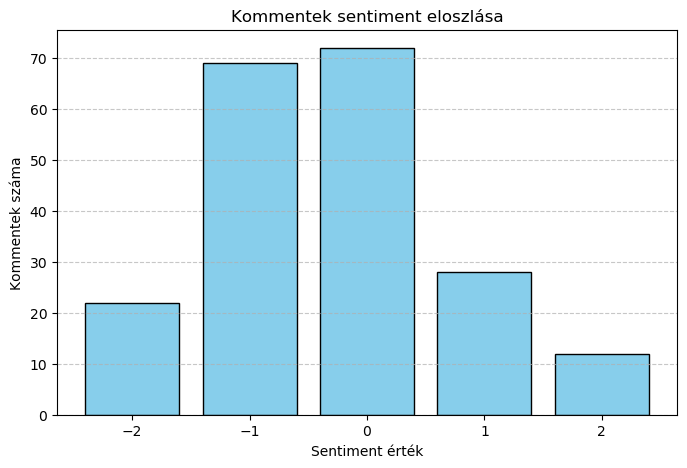

In [18]:
# A Kommentek szentimentjének eloszlása

plt.figure(figsize=(8,5))
plt.hist(comments_df["sentiment"], bins=[-2.5,-1.5,-0.5,0.5,1.5,2.5], 
         edgecolor='black', color='skyblue', rwidth=0.8)
plt.xticks([-2,-1,0,1,2])
plt.xlabel("Sentiment érték")
plt.ylabel("Kommentek száma")
plt.title("Kommentek sentiment eloszlása")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [19]:
polarization = comments_df["sentiment"].std()
print("Polarizáció (szórás):", polarization)

Polarizáció (szórás): 1.0308843428874437


In [20]:
#Idősoros polarizáció (kb. havonta, de a cikkeken múlik)
# Ez megmutatja, mely hónapokban volt a legnagyobb polarizáció.

comments_df.loc[:, "date"] = pd.to_datetime(comments_df["date"])

# hónapra csoportosítva szórás
monthly_polarization = comments_df.groupby(comments_df["date"].dt.to_period("M"))["sentiment"].std()
monthly_polarization

date
2023-04    1.064065
2025-01    0.995789
2025-02    0.707107
Freq: M, Name: sentiment, dtype: float64

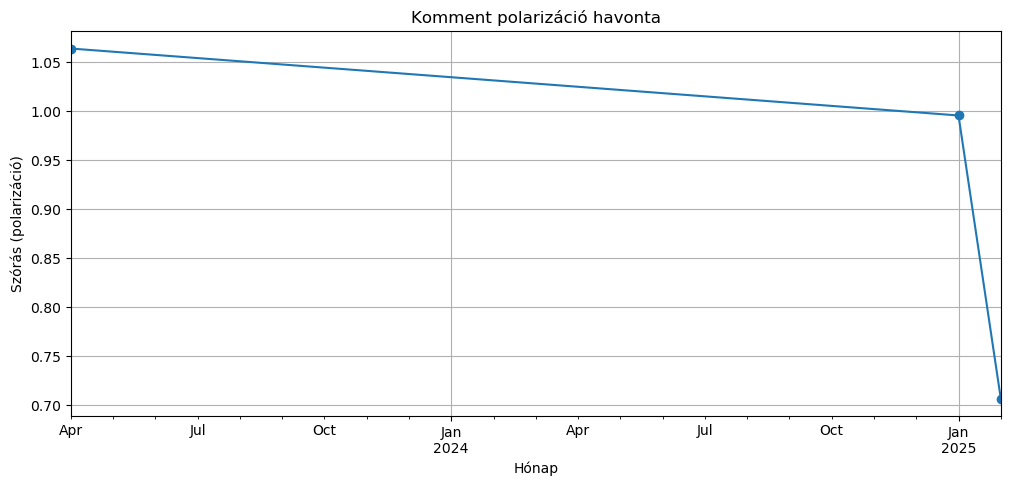

In [21]:
# A kommentek polarzációjának havi ábrázolása

monthly_polarization.plot(kind="line", marker="o", figsize=(12,5))
plt.title("Komment polarizáció havonta")
plt.xlabel("Hónap")
plt.ylabel("Szórás (polarizáció)")
plt.grid(True)
plt.show()